# Exercise 6

## Predict rating using LSTM


In [1]:
pip install nltk tensorflow

In [100]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, LSTM, GRU, Dropout, Input, Concatenate, Flatten
from tensorflow.keras.optimizers import Adam
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.stem import PorterStemmer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import string
import nltk

In [18]:
# Download stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [77]:
dataTraining = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)

In [78]:
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [40]:
plots = dataTraining['plot']
y = (dataTraining['rating'] >= dataTraining['rating'].mean()).astype(int)

In [10]:
plots

,plot
3107,most is the story of a single father who takes...
900,a serial killer decides to teach the secrets o...
6724,"in sweden , a female blackmailer with a disfi..."
4704,"in a friday afternoon in new york , the presi..."
2582,"in los angeles , the editor of a publishing h..."
...,...
8417,""" our marriage , their wedding . "" it ' s l..."
1592,"the wandering barbarian , conan , alongside ..."
1723,"like a tale spun by scheherazade , kismet fol..."
7605,"mrs . brisby , a widowed mouse , lives in a..."


In [11]:
y

,rating
3107,1
900,0
6724,1
4704,1
2582,1
...,...
8417,0
1592,0
1723,0
7605,1


# Exercise 6.1

- Remove stopwords
- Lowercase
- split the text in words
- pad_sequences

In [79]:
def preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    tokens = word_tokenize(text)
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

In [80]:
dataTraining['plot'] = dataTraining['plot'].fillna('').apply(preprocess_text)
dataTraining['title'] = dataTraining['title'].fillna('').apply(preprocess_text)

# Convertir la columna 'genres' a una lista de géneros
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))

# Binariza los géneros usando MultiLabelBinarizer
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [81]:
# Tokenización de 'plot' y 'title'
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(dataTraining['plot'])
X_seq_plot = tokenizer.texts_to_sequences(dataTraining['plot'])
X_seq_title = tokenizer.texts_to_sequences(dataTraining['title'])

# Padding para asegurar que todas las secuencias tengan la misma longitud
max_len = 100
X_seq_plot = pad_sequences(X_seq_plot, maxlen=max_len)
X_seq_title = pad_sequences(X_seq_title, maxlen=max_len)

In [82]:
# Simulando la binarización del rating
y_binary = (dataTraining['rating'] >= 5).astype(int)

In [83]:
# División en entrenamiento y prueba
X_train_plot, X_test_plot, X_train_title, X_test_title, X_train_genres, X_test_genres, y_train, y_test = train_test_split(
    X_seq_plot, X_seq_title, y_genres, y_binary, test_size=0.2, random_state=42)

In [84]:
def custom_accuracy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Aseguramos que y_true sea float32
    return tf.reduce_mean(tf.cast(tf.abs(y_true - y_pred) <= 0.5, tf.float32))

__________________________________________________________________________________________________________________________________________________________________________________________

# Exercise 6.2

Create a SimpleRNN neural network to predict the rating of a movie

Calculate the testing set accuracy

In [85]:
# Construcción del modelo RNN con entradas separadas
input_plot = Input(shape=(max_len,), name='input_plot')
input_title = Input(shape=(max_len,), name='input_title')

# Embedding y RNN para las secuencias de 'plot' y 'title'
embedding_layer = Embedding(input_dim=5000, output_dim=64, input_length=max_len)

# Procesamiento de 'plot'
plot_embedding = embedding_layer(input_plot)
plot_rnn = SimpleRNN(64)(plot_embedding)

# Procesamiento de 'title'
title_embedding = embedding_layer(input_title)
title_rnn = SimpleRNN(64)(title_embedding)

# Concatenar géneros con las salidas RNN
input_genres = Input(shape=(y_genres.shape[1],), name='input_genres')

# Concatenar las secuencias procesadas con los géneros binarizados
combined = Concatenate()([plot_rnn, title_rnn, input_genres])

# Capa densa final
dense = Dense(32, activation='relu')(combined)
output = Dense(1, activation='sigmoid')(dense)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [86]:
# Crear el modelo
model = Model(inputs=[input_plot, input_title, input_genres], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[custom_accuracy])

In [87]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_plot (InputLayer)   │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_title (InputLayer)  │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_6 (Embedding)   │ (None, 100, 64)        │        320,000 │ input_plot[0][0],      │
│                           │                        │                │ input_title[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ simple_rnn_9 (SimpleRNN)  │ (None, 64)             │          8,256 │ embedding_6[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ simple_rnn_10 (SimpleRNN) │ (None, 64)             │          8,256 │ embedding_6[1][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_genres (InputLayer) │ (None, 24)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 152)            │              0 │ simple_rnn_9[0][0],    │
│ (Concatenate)             │                        │                │ simple_rnn_10[0][0],   │
│                           │                        │                │ input_genres[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 32)             │          4,896 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 1)              │             33 │ dense_10[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 341,441 (1.30 MB)

 Trainable params: 341,441 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

In [88]:
# Entrenamiento del modelo
history = model.fit([X_train_plot, X_train_title, X_train_genres], y_train, epochs=10, batch_size=32, validation_data=([X_test_plot, X_test_title, X_test_genres], y_test))

# Predicciones y evaluación de accuracy
results = model.evaluate([X_test_plot, X_test_title, X_test_genres], y_test, verbose=1)
print(f'\nLoss: {results[0]} - Accuracy: {results[1] * 100:.2f}%')

Epoch 1/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/step - custom_accuracy: 0.8897 - loss: 0.3520 - val_custom_accuracy: 0.9076 - val_loss: 0.2907
Epoch 2/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 14s 69ms/step - custom_accuracy: 0.9091 - loss: 0.2510 - val_custom_accuracy: 0.8982 - val_loss: 0.2928
Epoch 3/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - custom_accuracy: 0.9659 - loss: 0.1018 - val_custom_accuracy: 0.8744 - val_loss: 0.4520
Epoch 4/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - custom_accuracy: 0.9982 - loss: 0.0119 - val_custom_accuracy: 0.8869 - val_loss: 0.6043
Epoch 5/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - custom_accuracy: 1.0000 - loss: 0.0017 - val_custom_accuracy: 0.8851 - val_loss: 0.6612
Epoch 6/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - custom_accuracy: 1.0000 - loss: 4.3319e-04 - val_custom_accuracy: 0.8863 - val_loss: 0.7019
Epoch 7/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - custom_accuracy: 1.0000 - loss: 2.6797e-04 - val_custom_accuracy: 0.8894 - v

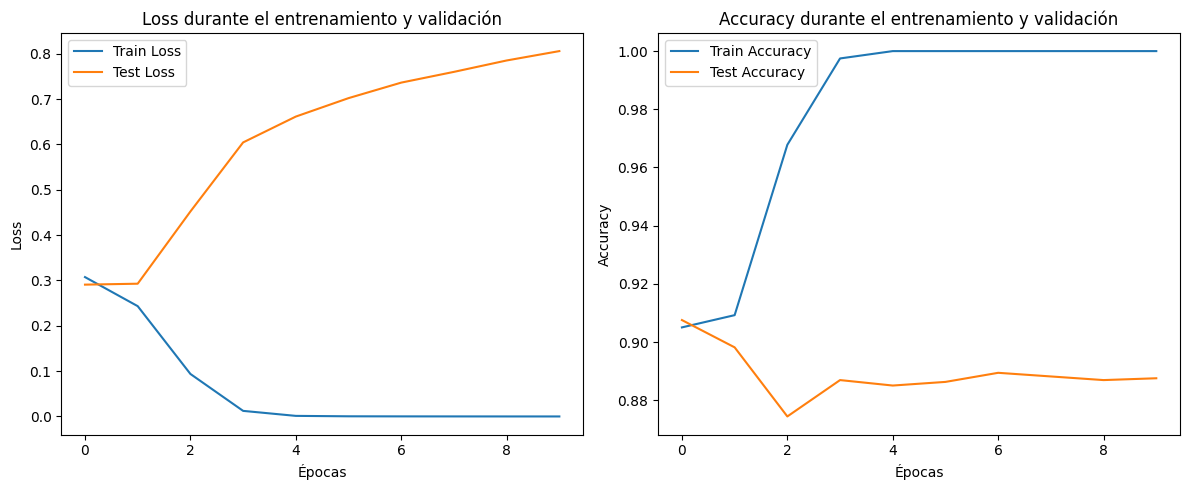

In [89]:
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

# Custom Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['custom_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_custom_accuracy'], label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

# Mostrar las gráficas
plt.tight_layout()
plt.show()

# Exercise 6.3

Create a LSTM neural network to predict the rating of a movie

Calculate the testing set accuracy

In [90]:
# Construcción del modelo LSTM con entradas separadas
input_plot = Input(shape=(max_len,), name='input_plot')
input_title = Input(shape=(max_len,), name='input_title')

# Embedding y LSTM para las secuencias de 'plot' y 'title'
embedding_layer = Embedding(input_dim=5000, output_dim=64, input_length=max_len)

# Procesamiento de 'plot'
plot_embedding = embedding_layer(input_plot)
plot_lstm = LSTM(64)(plot_embedding)

# Procesamiento de 'title'
title_embedding = embedding_layer(input_title)
title_lstm = LSTM(64)(title_embedding)

# Concatenar géneros con las salidas LSTM
input_genres = Input(shape=(y_genres.shape[1],), name='input_genres')

# Concatenar las secuencias procesadas con los géneros binarizados
combined = Concatenate()([plot_lstm, title_lstm, input_genres])

# Capa densa final
dense = Dense(32, activation='relu')(combined)
output = Dense(1, activation='sigmoid')(dense)

In [91]:
model = Model(inputs=[input_plot, input_title, input_genres], outputs=output)

In [93]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[custom_accuracy])

In [94]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_plot (InputLayer)   │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_title (InputLayer)  │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_7 (Embedding)   │ (None, 100, 64)        │        320,000 │ input_plot[0][0],      │
│                           │                        │                │ input_title[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 64)             │         33,024 │ embedding_7[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 64)             │         33,024 │ embedding_7[1][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_genres (InputLayer) │ (None, 24)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 152)            │              0 │ lstm[0][0],            │
│ (Concatenate)             │                        │                │ lstm_1[0][0],          │
│                           │                        │                │ input_genres[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 32)             │          4,896 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 1)              │             33 │ dense_12[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 390,977 (1.49 MB)

 Trainable params: 390,977 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

In [95]:
history_lstm = model.fit([X_train_plot, X_train_title, X_train_genres], y_train, epochs=10, batch_size=32, validation_data=([X_test_plot, X_test_title, X_test_genres], y_test))


Epoch 1/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 48s 206ms/step - custom_accuracy: 0.9006 - loss: 0.3654 - val_custom_accuracy: 0.9076 - val_loss: 0.2809
Epoch 2/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 29s 143ms/step - custom_accuracy: 0.9019 - loss: 0.2689 - val_custom_accuracy: 0.9001 - val_loss: 0.3001
Epoch 3/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 33s 104ms/step - custom_accuracy: 0.9443 - loss: 0.1397 - val_custom_accuracy: 0.8695 - val_loss: 0.3595
Epoch 4/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 42s 112ms/step - custom_accuracy: 0.9787 - loss: 0.0699 - val_custom_accuracy: 0.8719 - val_loss: 0.5667
Epoch 5/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 41s 111ms/step - custom_accuracy: 0.9935 - loss: 0.0258 - val_custom_accuracy: 0.8726 - val_loss: 0.6828
Epoch 6/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 22s 111ms/step - custom_accuracy: 0.9996 - loss: 0.0050 - val_custom_accuracy: 0.8576 - val_loss: 0.9089
Epoch 7/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 41s 111ms/step - custom_accuracy: 0.9999 - loss: 0.0020 - val_custom_accuracy: 0.8695 - va

In [112]:
results = model.evaluate([X_test_plot, X_test_title, X_test_genres], y_test, verbose=1)
print(f'\nLoss: {results[0]} - Accuracy: {results[1] * 100:.2f}%')

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - custom_accuracy: 0.8533 - loss: 1.2309

Loss: 1.1863096952438354 - Accuracy: 86.20%


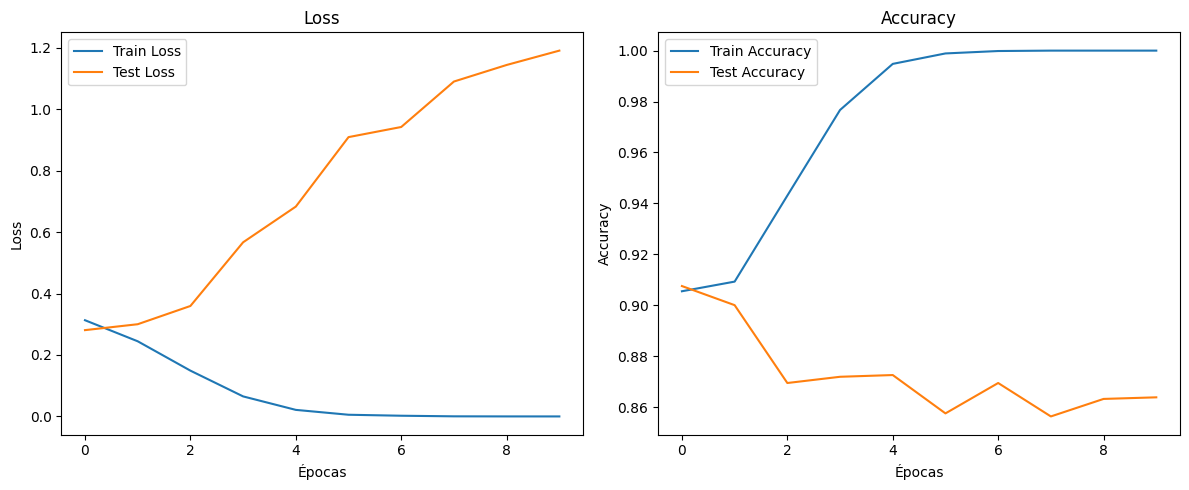

In [111]:
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Test Loss')
plt.title('Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['custom_accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_custom_accuracy'], label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

# Mostrar las gráficas
plt.tight_layout()
plt.show()

# Exercise 6.4

Create a GRU neural network to predict the rating of a movie

Calculate the testing set accuracy

In [101]:
# Construcción del modelo GRU con entradas separadas
input_plot = Input(shape=(max_len,), name='input_plot')
input_title = Input(shape=(max_len,), name='input_title')

# Embedding y GRU para las secuencias de 'plot' y 'title'
embedding_layer = Embedding(input_dim=5000, output_dim=64, input_length=max_len)

# Procesamiento de 'plot'
plot_embedding = embedding_layer(input_plot)
plot_gru = GRU(64)(plot_embedding)

# Procesamiento de 'title'
title_embedding = embedding_layer(input_title)
title_gru = GRU(64)(title_embedding)

# Concatenar géneros con las salidas GRU
input_genres = Input(shape=(y_genres.shape[1],), name='input_genres')

# Concatenar las secuencias procesadas con los géneros binarizados
combined = Concatenate()([plot_gru, title_gru, input_genres])

# Capa densa final
dense = Dense(32, activation='relu')(combined)
output = Dense(1, activation='sigmoid')(dense)  # Clasificación binaria

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [103]:
model = Model(inputs=[input_plot, input_title, input_genres], outputs=output)

In [104]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[custom_accuracy])

In [105]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_plot (InputLayer)   │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_title (InputLayer)  │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_9 (Embedding)   │ (None, 100, 64)        │        320,000 │ input_plot[0][0],      │
│                           │                        │                │ input_title[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru (GRU)                 │ (None, 64)             │         24,960 │ embedding_9[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_1 (GRU)               │ (None, 64)             │         24,960 │ embedding_9[1][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_genres (InputLayer) │ (None, 24)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 152)            │              0 │ gru[0][0],             │
│ (Concatenate)             │                        │                │ gru_1[0][0],           │
│                           │                        │                │ input_genres[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 32)             │          4,896 │ concatenate_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 1)              │             33 │ dense_14[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 374,849 (1.43 MB)

 Trainable params: 374,849 (1.43 MB)

 Non-trainable params: 0 (0.00 B)

In [106]:
history = model.fit([X_train_plot, X_train_title, X_train_genres], y_train, epochs=10, batch_size=32, validation_data=([X_test_plot, X_test_title, X_test_genres], y_test))

Epoch 1/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 39s 170ms/step - custom_accuracy: 0.8358 - loss: 0.3957 - val_custom_accuracy: 0.9076 - val_loss: 0.2889
Epoch 2/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 34s 136ms/step - custom_accuracy: 0.9044 - loss: 0.2657 - val_custom_accuracy: 0.9026 - val_loss: 0.2995
Epoch 3/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 40s 132ms/step - custom_accuracy: 0.9346 - loss: 0.1591 - val_custom_accuracy: 0.8770 - val_loss: 0.4112
Epoch 4/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - custom_accuracy: 0.9752 - loss: 0.0715 - val_custom_accuracy: 0.8701 - val_loss: 0.5348
Epoch 5/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 31s 141ms/step - custom_accuracy: 0.9917 - loss: 0.0268 - val_custom_accuracy: 0.8520 - val_loss: 0.7034
Epoch 6/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 38s 127ms/step - custom_accuracy: 0.9969 - loss: 0.0110 - val_custom_accuracy: 0.8589 - val_loss: 0.8324
Epoch 7/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 41s 130ms/step - custom_accuracy: 0.9998 - loss: 0.0023 - val_custom_accuracy: 0.8689 - va

In [109]:
results = model.evaluate([X_test_plot, X_test_title, X_test_genres], y_test, verbose=1)
print(f'\nLoss: {results[0]} - Accuracy: {results[1] * 100:.2f}%')

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - custom_accuracy: 0.8533 - loss: 1.2309

Loss: 1.1863096952438354 - Accuracy: 86.20%


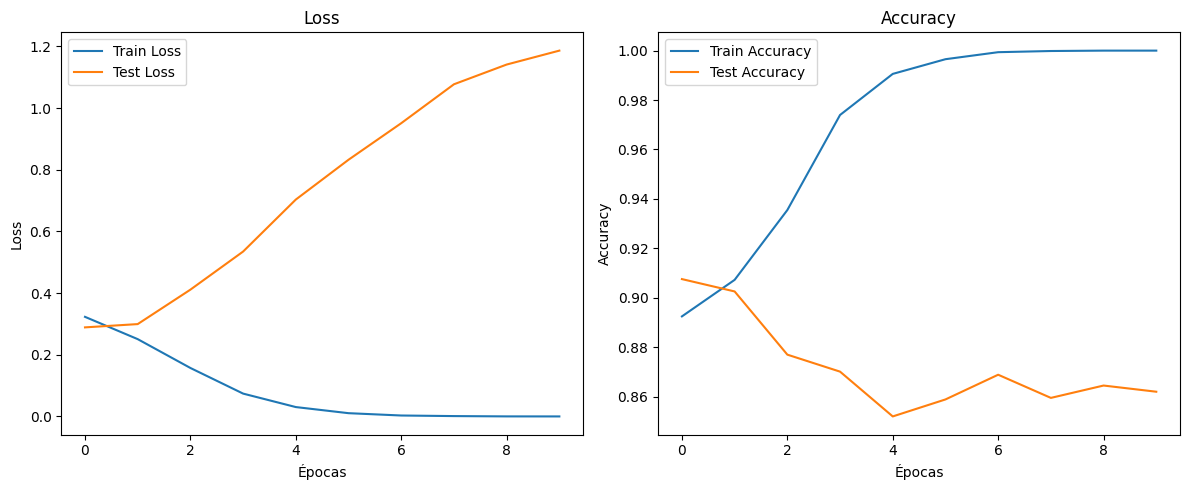

In [110]:
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['custom_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_custom_accuracy'], label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

# Mostrar las gráficas
plt.tight_layout()
plt.show()